# Praca domowa 2
### Paulina Jaszczuk

## Import pakietów

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

## Import zbioru `apartments`

In [2]:
from dalex.datasets import load_apartments
apartments_df = load_apartments()
apartments_df.head()

,m2_price,construction_year,surface,floor,no_rooms,district
1,5897,1953,25,3,1,Srodmiescie
2,1818,1992,143,9,5,Bielany
3,3643,1937,56,1,2,Praga
4,3517,1995,93,7,3,Ochota
5,3013,1992,144,6,5,Mokotow


## Krótkie EDA 

Zbiór `apartments` zawiera dane dotyczące mieszkań. Posiada on 5 zmienych - `rok budowy`, `powierzchnia`, `piętro`, `liczba pokoi` i `dzielnica` oraz target `cena za m2`. 

In [3]:
apartments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2_price           1000 non-null   int64 
 1   construction_year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no_rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 54.7+ KB


Nasze dane nie zawierają wartości brakujących. 4 cechy są numeryczne, 1 kategoryczna.

In [4]:
apartments_df.describe()

,m2_price,construction_year,surface,floor,no_rooms
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3487.019000,1964.823000,85.590000,5.623000,3.360000
std,906.691651,25.831511,37.874799,2.899876,1.381415
min,1607.000000,1920.000000,20.000000,1.000000,1.000000
25%,2857.000000,1943.000000,53.000000,3.000000,2.000000
50%,3386.000000,1965.000000,85.500000,6.000000,3.000000
75%,4018.250000,1988.000000,118.000000,8.000000,4.000000
max,6595.000000,2010.000000,150.000000,10.000000,6.000000


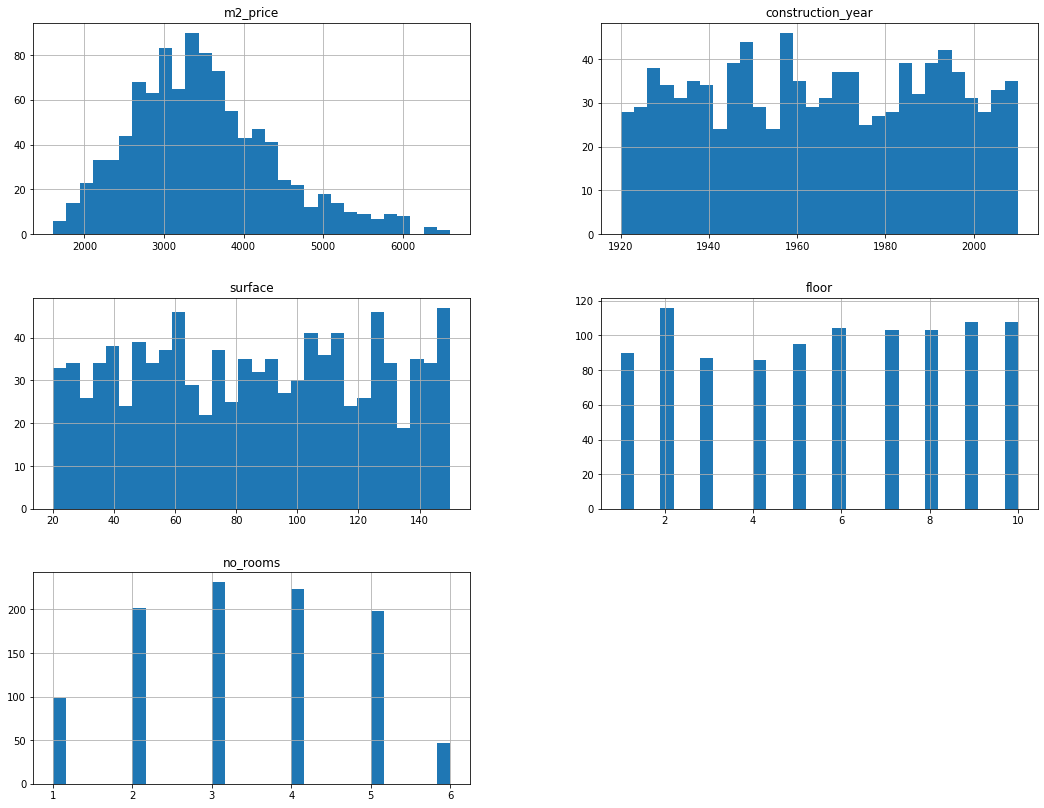

In [5]:
apartments_df.hist(figsize=(18,14), bins=30)
plt.show()

Nasz target ma rozkład zbliżony do normalnego.

In [6]:
apartments_df['district'].value_counts()

Mokotow        107
Wola           106
Ursus          105
Ursynow        103
Srodmiescie    100
Bemowo          98
Zoliborz        97
Bielany         96
Ochota          96
Praga           92
Name: district, dtype: int64

Jedyna zmienna kategoryczna z naszego zbioru danych - `district` - przyjmuje 10 wartości. Ta informacja przyda się nam przy kodowaniu.

## Import zbioru `diabetes` z pakietu sklearn

In [7]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes(as_frame=True)
diabetes_df = diabetes['data']
diabetes_target = diabetes['target']
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


## Krótkie EDA

Zbiór danych `diabetes` z pakietu sklearn zawiera informacje dotyczące pacjentów chorych na cukrzycę.

In [8]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


Zbiór danych zawiera 10 kolumn numerycznych: `wiek`, `płeć`, `bmi`, `średnie ciśnienie krwi` oraz 6 zmiennych dotyczących bardziej szczegółowych składników krwi: `s1` - limfocyty T (tc), `s2` - lipoproteiny o małej gęstości (ldl), `s3` - lipoproteiny o dużej gęstości (hdl), `s4` - hormon stymulujący tarczycę (thc), `s5` - lamotrygina (ltg), `s6` - poziom cukru we krwi (glu). Wszystkie zmienne są numeryczne. Przedmiotem naszego jest predykcja ilościowej miary postępu choroby rok po wizycie początkowej. W zbiorze nie ma wartości brakujących.

In [9]:
diabetes_df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


Z charakterystyki danych możemy się dowiedzieć, że każda z 10 zmiennych cech została wyśrodkowana i przeskalowana, stosując odchylenie standardowe (tj. suma kwadratów każdej kolumny wynosi 1), czego odzwierciedlenie możemy zobaczyć na poniższych rozkładach.

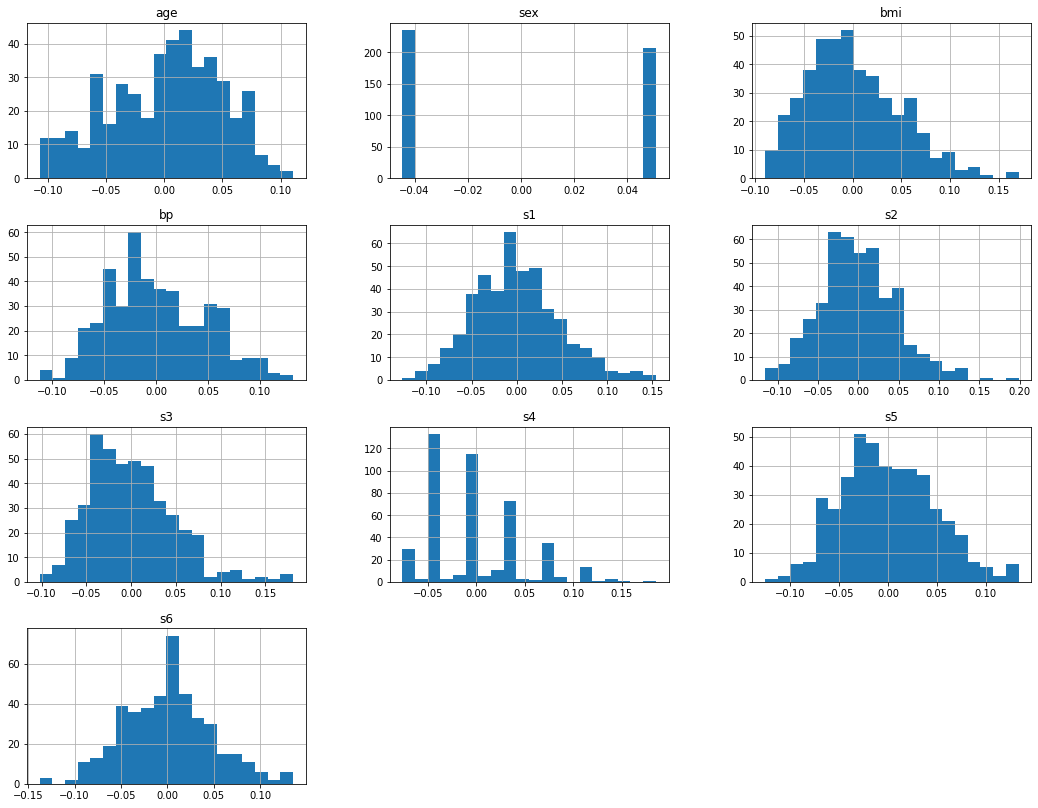

In [10]:
diabetes_df.hist(figsize=(18,14), bins=20)
plt.show()

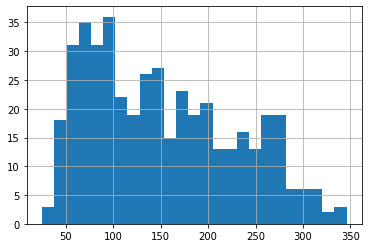

In [11]:
diabetes_target.hist(bins = 25)
plt.show()

## Przygotowanie danych

### Podział zbiorów

In [12]:
# apartments
x_apartments_train, x_apartments_test, y_apartments_train, y_apartments_test = train_test_split(
    apartments_df.drop(columns=['m2_price']), apartments_df['m2_price'], test_size=0.2, random_state=42)

# diabetes
x_diabetes_train, x_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(
    diabetes_df, diabetes_target, test_size=0.2, random_state=42)

### Kodowanie zmiennych kategorycznych

In [13]:
# apartments
x_apartments_train = pd.get_dummies(data = x_apartments_train, columns = ['district'])
x_apartments_test = pd.get_dummies(data = x_apartments_test, columns = ['district'])

In [14]:
x_apartments_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 30 to 103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   construction_year     800 non-null    int64
 1   surface               800 non-null    int64
 2   floor                 800 non-null    int64
 3   no_rooms              800 non-null    int64
 4   district_Bemowo       800 non-null    uint8
 5   district_Bielany      800 non-null    uint8
 6   district_Mokotow      800 non-null    uint8
 7   district_Ochota       800 non-null    uint8
 8   district_Praga        800 non-null    uint8
 9   district_Srodmiescie  800 non-null    uint8
 10  district_Ursus        800 non-null    uint8
 11  district_Ursynow      800 non-null    uint8
 12  district_Wola         800 non-null    uint8
 13  district_Zoliborz     800 non-null    uint8
dtypes: int64(4), uint8(10)
memory usage: 39.1 KB


Zmienna `district` ma stosunkowo niewiele wartości, daltego do jej zakodowania użyłam One-hot Encoding. W zbiorze `diabetes` nie ma kolumn kategorycznych.

### Skalowanie

In [15]:
preprocessing = StandardScaler()

Dalej będziemy stosować pipeline'y.

## Modelowanie

Zastosujemy algorytm Support Vector Machine w wersji dla zadania regresji. Nauczymy nasz model na zbiorach `apartments` w wersji przeskalowanej i oryginalnej oraz `diabetes`, które już oryginalnie jest przeskalowany. Do oceny miary jakości modeli użyjemy błędu średnio kwadratowego. MSE policzymy zarówno na zbiorze testowym i treningowym. 

In [16]:
# apartemnts unscaled
svm_apartments_unscaled = SVR()
svm_apartments_unscaled.fit(x_apartments_train, y_apartments_train)

print('MSE train: ', mean_squared_error(y_apartments_train, svm_apartments_unscaled.predict(x_apartments_train), squared=False))
print('MSE test: ', mean_squared_error(y_apartments_test, svm_apartments_unscaled.predict(x_apartments_test), squared=False))

MSE train:  898.5448498842396
MSE test:  973.966883319658


In [17]:
# apartments scaled
svm_apartments_scaled = make_pipeline(preprocessing, SVR())
svm_apartments_scaled.fit(x_apartments_train, y_apartments_train)

print('MSE train: ', mean_squared_error(y_apartments_train, svm_apartments_scaled.predict(x_apartments_train), squared=False))
print('MSE test: ', mean_squared_error(y_apartments_test, svm_apartments_scaled.predict(x_apartments_test), squared=False))

MSE train:  875.3258603050316
MSE test:  950.6873009094581


Jak widzimy, skalowanie danych zmniejszyło MSE zarówno na zbiorze treningowym jak i testowym o około 20. Nie jest to spektakularna różnica, aczkolwiek widoczna. Skalowanie danych nie zmniejszyło natomiast różnicy pomiędzy jakością predykcji na zbiorze treningowym i testowym.

In [18]:
# diabetes
svm_diabetes = SVR()
svm_diabetes.fit(x_diabetes_train, y_diabetes_train)

print('MSE train: ', mean_squared_error(y_diabetes_train, svm_diabetes.predict(x_diabetes_train), squared=False))
print('MSE test: ', mean_squared_error(y_diabetes_test, svm_diabetes.predict(x_diabetes_test), squared=False))

MSE train:  71.15345965488882
MSE test:  65.82766241937706


Zbiór `diabetes` jest już przeskalowany, więc nie ma sensu robić skalowania jeszcze raz i modelowania nowopowstałego zbioru.

## Strojenie parametrów

Będziemy stroić hiperparametry modelu metodą Random Search.

In [24]:
# apartments
params = {'svr__C': np.arange(0.1, 1000, 0.1),
            'svr__gamma': ['scale', 'auto', 1],
            'svr__degree': np.arange(1,  10, 1),
            'svr__kernel':['rbf']}

random = RandomizedSearchCV(estimator=make_pipeline(preprocessing, SVR()), param_distributions=params, n_iter= 100, n_jobs=-1)

random_result = random.fit(x_apartments_train, y_apartments_train)

best_estimator = random.best_estimator_
print(random_result.best_params_)

{'svr__kernel': 'rbf', 'svr__gamma': 'scale', 'svr__degree': 8, 'svr__C': 985.9000000000001}


Przy każdym wywołaniu Random Search, otrzymujmy nieco inne wyniki - parametr `gamma` najczęściej przyjmuje wartość 'scale', `degree` przyjmuje wartości m.in 6, 7 i 8, zaś `cost` w okolicach 990. 

In [20]:
print('MSE train for best estimator: ', mean_squared_error(y_apartments_train, best_estimator.predict(x_apartments_train), squared=False))
print('MSE test for best estimator: ', mean_squared_error(y_apartments_test, best_estimator.predict(x_apartments_test), squared=False))

MSE train for best estimator:  142.67520716163304
MSE test for best estimator:  174.60015012529945


Mimo pewnej nieprzewidywalności hiperparametrów, MSE jest zaskakująco stałe i dla zbioru treningowego przyjmuje wartość w okolicach 142, a dla zbioru testowego - 175. Jest to ogromny spadek w porównaniu do niestrojonych modeli.

In [21]:
# diabetes
svr_diabetes = make_pipeline(SVR())
random_diabetes = RandomizedSearchCV(estimator=svr_diabetes, param_distributions=params, n_iter= 100, n_jobs=-1)

random_result_diabetes = random_diabetes.fit(x_diabetes_train, y_diabetes_train)

best_estimator_diabetes = random_diabetes.best_estimator_
print(random_result_diabetes.best_params_)

{'svr__kernel': 'rbf', 'svr__gamma': 1, 'svr__degree': 2, 'svr__C': 223.9}


W wypadku tego zbioru parametry to: 1 dla `gamma`, około 220 dla `cost` natomiast parametr `degree` jest nieprzewidywalny i przyjmuje przeróżne wartości. 
Nie wiem dlaczego funkcja RandomizedSearchCV nie przyjmowała parametru estimator=SVR(), zaś przyjmowała pipeline.

In [22]:
print('MSE train for best estimator: ', mean_squared_error(y_diabetes_train, best_estimator_diabetes.predict(x_diabetes_train), squared=False))
print('MSE test for best estimator: ', mean_squared_error(y_diabetes_test, best_estimator_diabetes.predict(x_diabetes_test), squared=False))

MSE train for best estimator:  53.851371074641456
MSE test for best estimator:  53.978458356058994


MSE kolejny raz jest dość stabilne i przyjmuje wartość około 53 zarówno dla zbioru treningowego i testowego. Strojenie parametrów kolejny raz widocznie zredukowało MSE oraz różnice między predykcją na zbiorze testowym i treningowym.